In [1]:
from importlib import reload
import json
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import modules.midiMethods as midiMethods
reload(midiMethods)
from modules.midiMethods import *

import modules.dataMethods as dataMethods
reload(dataMethods)
from modules.dataMethods import *

import modules.models as models
reload(models)

import modules.mlClasses as mlClasses
reload(mlClasses)

import ast

## Data Exploration
This notebook contains the code needed to make the plots found in the project report, and a few other plots besides. This includes comparisons of training and validation loss for different model configurations. 

In [2]:
# if needed, read in filenames... specify if validation or test
# we'll validation for the purpose of having a smaller sample for some plots 
data_path = 'training_data/MaestroV2.00/maestro-v2.0.0/'
maestro = pd.read_csv('training_data/maestro-v2.0.0withPeriod.csv', index_col=0)
filenames = list(maestro[maestro['split'] == 'validation']['midi_filename'])

In [4]:
# load data
with open('training_data/oore_v1/oore_train.json', 'r') as f:
    X_train = json.load(f)
    
with open('training_data/oore_v1/oore_val.json', 'r') as f:
    X_val = json.load(f)

In [3]:
#### Graphing note lengths and durations
lengths = []
shifts = []

for i in range(len(filenames)):
    if i % 20 == 0:
        print(f'file {i} of {len(filenames)}')
    pm = pretty_midi.PrettyMIDI(data_path + filenames[i])
    sustain_only(pm)
    desus(pm)
    pm.instruments[0].notes.sort(key = lambda x: x.start)
    last_note_start = 0
    for note in pm.instruments[0].notes:
        lengths.append(note.end - note.start)
        shifts.append(note.start - last_note_start)
        last_note_start = note.start
        
    

file 0 of 137
file 20 of 137
file 40 of 137
file 60 of 137
file 80 of 137
file 100 of 137
file 120 of 137


In [13]:
np.mean(shifts) * 256

27.848998501257636

In [4]:
# Get the fraction of notes omitted due to cutoff times
length_p = []
duration_p = []
lengths_np = np.array(shifts)
shifts_np = np.array(lengths)
for i in range(20):
    length_p.append(sum(lengths_np > i) / len(lengths))
    duration_p.append(sum(shifts_np > i) / len(shifts))

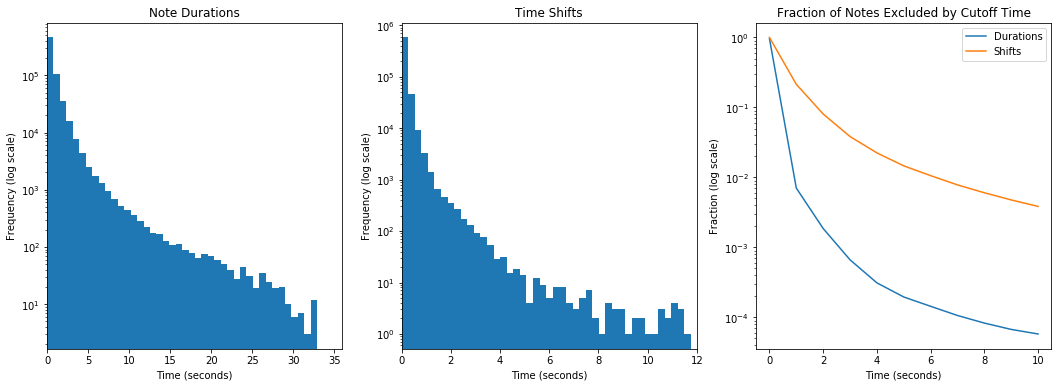

In [11]:
# graph note lengths, and time between notes
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.xlim((0,36))
plt.hist(lengths, bins=42)
plt.yscale('log')
plt.title('Note Durations')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (log scale)')

plt.subplot(132)
plt.xlim((0,12))
plt.hist(shifts, bins=81)
plt.yscale('log')
plt.title('Time Shifts')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (log scale)')

plt.subplot(133)
plt.plot(length_p[:11])
plt.plot(duration_p[:11])
plt.title('Fraction of Notes Excluded by Cutoff Time')
plt.ylabel('Fraction (log scale)')
plt.yscale('log')
plt.xlabel('Time (seconds)')
plt.legend(['Durations', 'Shifts'], loc='upper right')


In [46]:
# fraction of lengths or durations longer than a particular value
print(sum(np.array(lengths) > 10) / len(lengths))
print(sum(np.array(shifts) > 10) / len(shifts))

0.0038518981897798805
5.7864487625601126e-05


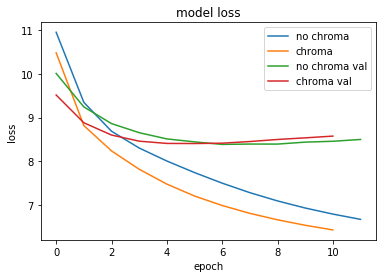

In [2]:
# First experiment showing chroma works.
import ast
with open(f'models/nbc/nbcmodel3/history40e.json', 'r') as f:
    hist = ast.literal_eval(json.load(f))
with open(f'models/nbc/nbcmodel4/history40e.json', 'r') as f:
    hist2 = ast.literal_eval(json.load(f))
metric = 'loss'
# print(hist)
plt.plot(hist[metric])
plt.plot(hist2[metric])
plt.plot(hist['val_' + metric])
plt.plot(hist2['val_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['no chroma', 'chroma', 'no chroma val', 'chroma val'], loc='upper right')
plt.savefig('?')
plt.show()

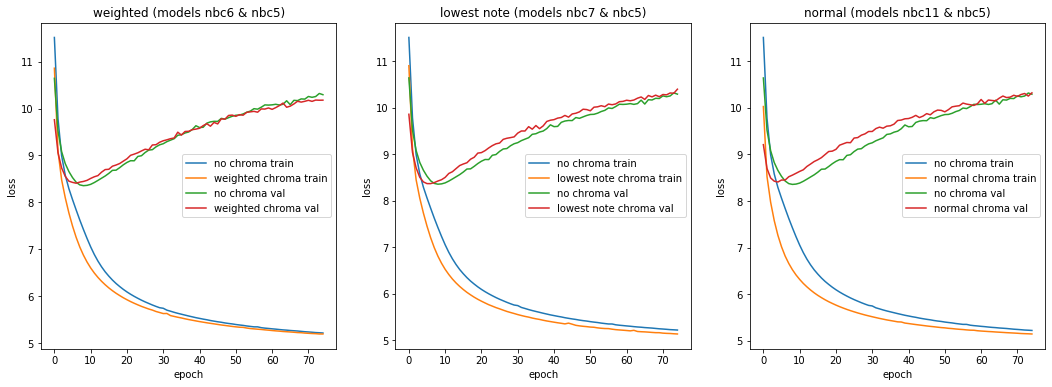

In [52]:
# Comparison of the four different chroma schemes with no chroma
chroma_type = {6: 'weighted', 7: 'lowest note', 11: 'normal'}
graph_pos = 131
plt.figure(figsize=(18,6))
for no, chroma in chroma_type.items():
    with open(f'models/nbc/nbcmodel5/history75e.json', 'r') as f:
        hist = ast.literal_eval(json.load(f))
    with open(f'models/nbc/nbcmodel{no}/history75e.json', 'r') as f:
        hist2 = ast.literal_eval(json.load(f))
    plt.subplot(graph_pos)
    graph_pos += 1
    metric = 'loss'
    # print(hist)
    plt.plot(hist[metric])
    plt.plot(hist2[metric])
    plt.plot(hist['val_' + metric])
    plt.plot(hist2['val_' + metric])
    plt.title(chroma + f' (models nbc{no} & nbc5)')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['no chroma train', chroma + ' chroma train', 'no chroma val', chroma + ' chroma val'], loc='right')
# plt.savefig('?')
plt.show()

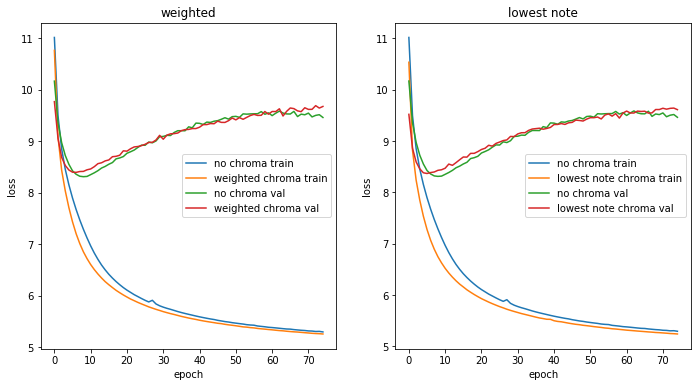

In [4]:
# Comparison of weighted and lowest note, when transposition is applied.
chroma_type = {9: 'weighted', 10: 'lowest note'}
graph_pos = 131
plt.figure(figsize=(18,6))
for no, chroma in chroma_type.items():
    with open(f'models/nbc/nbcmodel8/history75e.json', 'r') as f:
        hist = ast.literal_eval(json.load(f))
    with open(f'models/nbc/nbcmodel{no}/history75e.json', 'r') as f:
        hist2 = ast.literal_eval(json.load(f))
    plt.subplot(graph_pos)
    graph_pos += 1
    metric = 'loss'
    # print(hist)
    plt.plot(hist[metric])
    plt.plot(hist2[metric])
    plt.plot(hist['val_' + metric])
    plt.plot(hist2['val_' + metric])
    plt.title(chroma)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['no chroma train', chroma + ' chroma train', 'no chroma val', chroma + ' chroma val'], loc='right')
# plt.savefig('?')
plt.show()

9.335865358027016
10.52765391512615


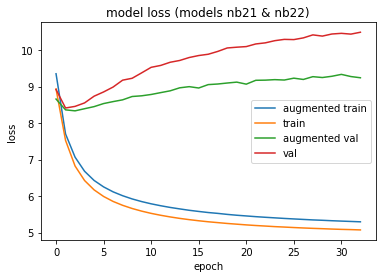

In [53]:
# comparison of nbmodel 21 with 22, showing that augmentation reduces overfitting
with open(f'models/nb/nbmodel21/history33e.json', 'r') as f:
    hist33 = ast.literal_eval(json.load(f))
with open(f'models/nb/nbmodel22/history99e.json', 'r') as f:
    hist99 = ast.literal_eval(json.load(f))

new_hist99 = {}
for key, value in hist99.items():
    new_hist99[key] = [v for i, v in enumerate(value) if i % 3 == 1]

print(max(hist33['val_loss']))
print(max(hist99['val_loss']))
metric = 'loss'
plt.plot(hist33[metric])
plt.plot(new_hist99[metric])
plt.plot(hist33['val_' + metric])
plt.plot(new_hist99['val_' + metric])
plt.title('model ' + metric + ' (models nb21 & nb22)')
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend(['augmented train', 'train', 'augmented val', 'val'], loc='right')
# plt.savefig('?')
plt.show()

In [ ]:
# plot loss for each note attribute - could check out how augmentation affects each attribute individually
metric = 'loss'
# print(hist)
plt.plot(hist['dense_1_' + metric])
plt.plot(hist['dense_2_' + metric])
plt.plot(hist['dense_3_' + metric])
plt.plot(hist['dense_4_' + metric])
plt.plot(hist['dense_5_' + metric])
plt.plot(hist['dense_' + metric])
plt.title('model ' + metric)
plt.ylabel(metric)
plt.xlabel('epoch')
plt.legend([f'dense_{i}' + metric for i in range(1,6)], loc='upper left')
plt.show()